# XGBoost Model-based Alpha Signal Prediction using Microblogging Data from social media 

In [102]:
#pip install missingno

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
import re, string, unicodedata
from sklearn.model_selection import train_test_split
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder


# Dataset

In [104]:
data = pd.read_csv('dataset.csv')

In [105]:
data.tail()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
27001,27002,05/10/18,$RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3
27002,27003,30/07/18,$PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3
27003,27004,16/10/18,$JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2
27004,27005,27/07/18,$NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3
27005,27006,14/10/18,$WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2


# Exploratory Data Analysis

In [106]:
data.describe(include = 'all')

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
count,27006.000000,27006,27006,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000,27006.000000
unique,NaN,123,1304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,26/07/18,$BAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,344,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,13503.500000,NaN,NaN,0.005429,-0.001005,-0.024421,-0.042420,0.041465,0.002597,0.036744,2.379582
std,7796.105021,NaN,NaN,0.941853,0.996130,0.539555,1.111309,0.976028,0.998839,1.204473,1.008681
min,1.000000,NaN,NaN,-4.114670,-4.578587,-2.609150,-6.329798,-5.480268,-4.338751,-5.347869,1.000000
25%,6752.250000,NaN,NaN,-0.596792,-0.666310,-0.300187,-0.767247,-0.518641,-0.668027,-0.688198,2.000000
50%,13503.500000,NaN,NaN,0.012104,-0.013257,-0.040786,-0.058629,0.072127,0.007417,0.081374,2.000000
75%,20254.750000,NaN,NaN,0.611574,0.669094,0.241424,0.677433,0.616538,0.674592,0.807556,3.000000


### Missing Value

Id        0
date      0
ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
alpha     0
dtype: int64

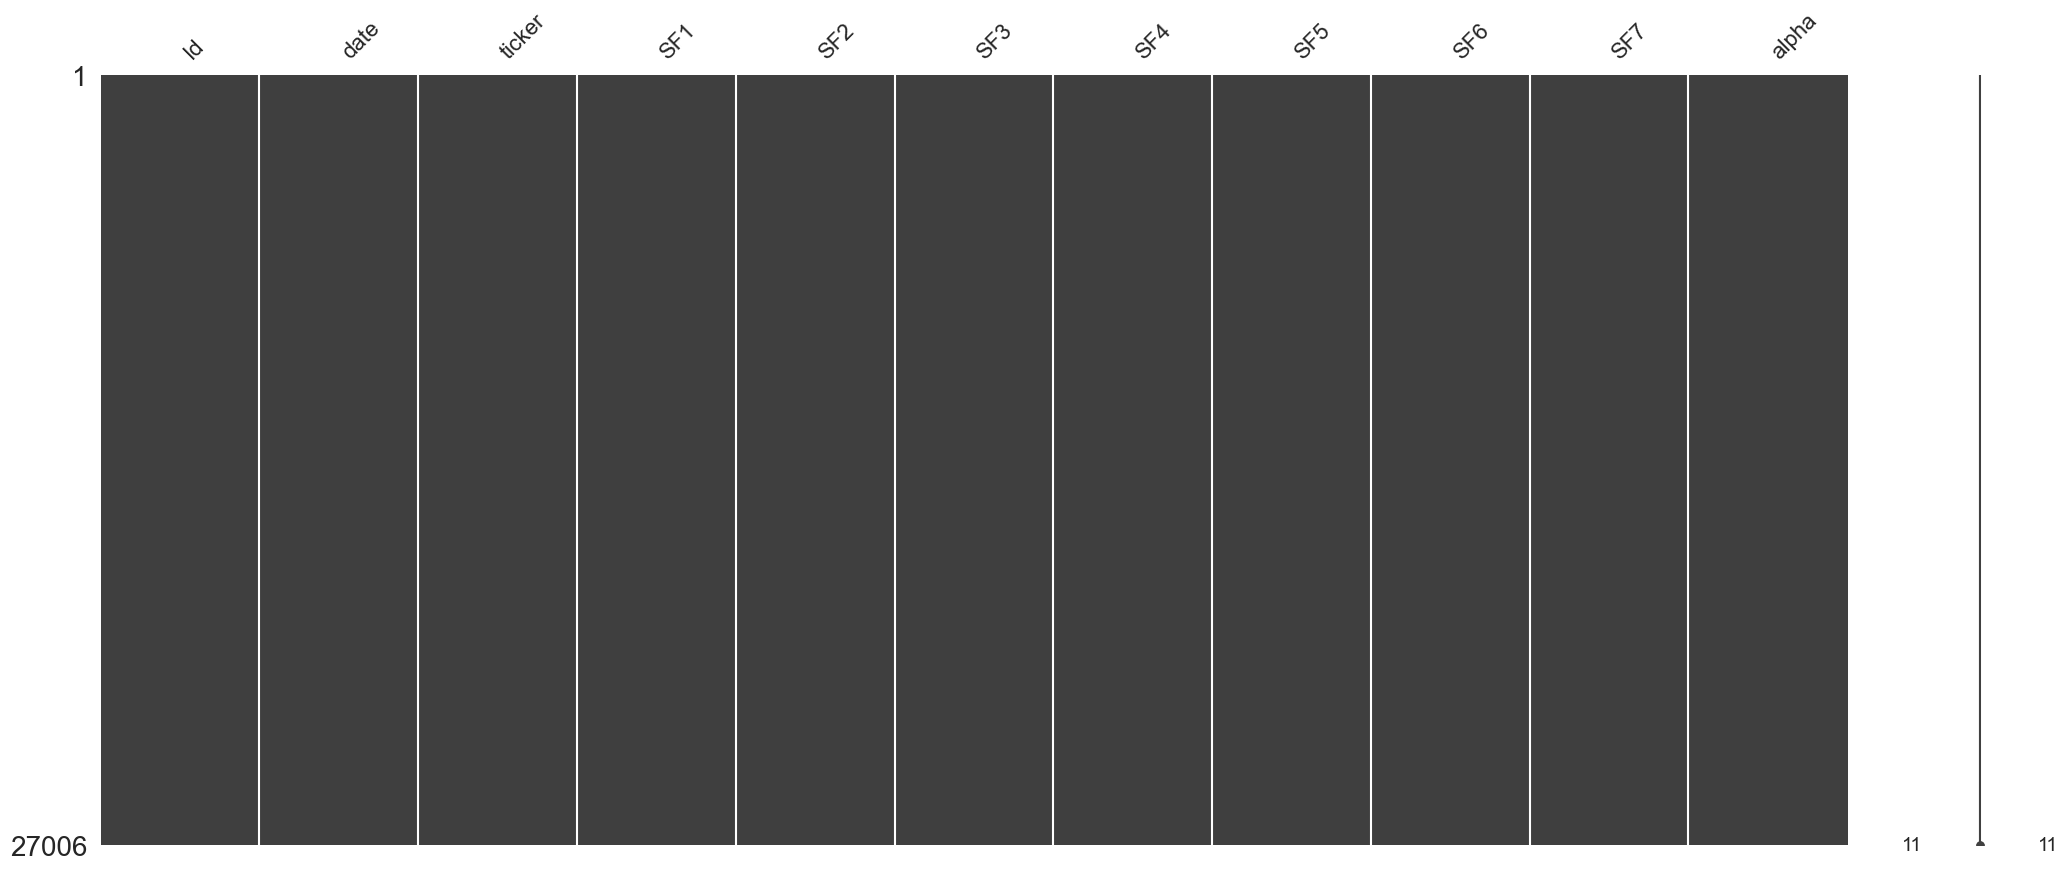

In [107]:
msno.matrix(data)
data.isnull().sum()

### Data Types

In [108]:
data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
dtype: object

In [109]:
for i in data.columns:
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('category')

# Data Preprocessing

In [110]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [111]:
unique_days=data.date.str.split('/', expand = True)[0].unique()
unique_days

array(['21', '11', '10', '12', '16', '25', '27', '24', '15', '31', '28',
       '09', '04', '26', '23', '06', '17', '18', '19', '05', '08', '01',
       '03', '02', '07', '22', '30', '29', '20', '14', '13'], dtype=object)

In [112]:
print('Unique Days for which data is collected -', data['date'].str.split('/', expand = True)[0].unique(),
      '\nUnique Months for which data is collected -', data['date'].str.split('/', expand = True)[1].unique(),
      '\nUnique Years for which data is collected -', data['date'].str.split('/', expand = True)[2].unique())

Unique Days for which data is collected - ['21' '11' '10' '12' '16' '25' '27' '24' '15' '31' '28' '09' '04' '26'
 '23' '06' '17' '18' '19' '05' '08' '01' '03' '02' '07' '22' '30' '29'
 '20' '14' '13'] 
Unique Months for which data is collected - ['08' '10' '07' '09'] 
Unique Years for which data is collected - ['18']


In [113]:
months=data.date.str.split('/', expand = True)[1].unique()
months

array(['08', '10', '07', '09'], dtype=object)

In [114]:
Years=data.date.str.split('/', expand = True)[2].unique()
Years

array(['18'], dtype=object)

In [115]:
data['Day'] = data['date'].str.split('/', expand = True)[0]
data['Month'] =data['date'].str.split('/', expand = True)[1]

In [116]:
# Stripping '$' from ticker
data['ticker'] = data['ticker'].str.split('$', expand = True)[1]

In [117]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
0,1,21/08/18,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,08
1,2,11/10/18,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,10
2,3,21/08/18,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,21,08
3,4,10/07/18,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,10,07
4,5,12/09/18,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,12,09


In [118]:
data.alpha.unique()

array([2, 3, 1, 4], dtype=int64)

In [119]:
data.dtypes

Id           int64
date      category
ticker      object
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
alpha        int64
Day         object
Month       object
dtype: object

In [120]:
data['ticker'] = data['ticker'].astype('category')
data['Day'] = data['Day'].astype('int')
data['Month'] = data['Month'].astype('int')

# Data Visualization

In [121]:
data.tail()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
27001,27002,05/10/18,RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,5,10
27002,27003,30/07/18,PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,30,7
27003,27004,16/10/18,JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,16,10
27004,27005,27/07/18,NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,27,7
27005,27006,14/10/18,WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2,14,10


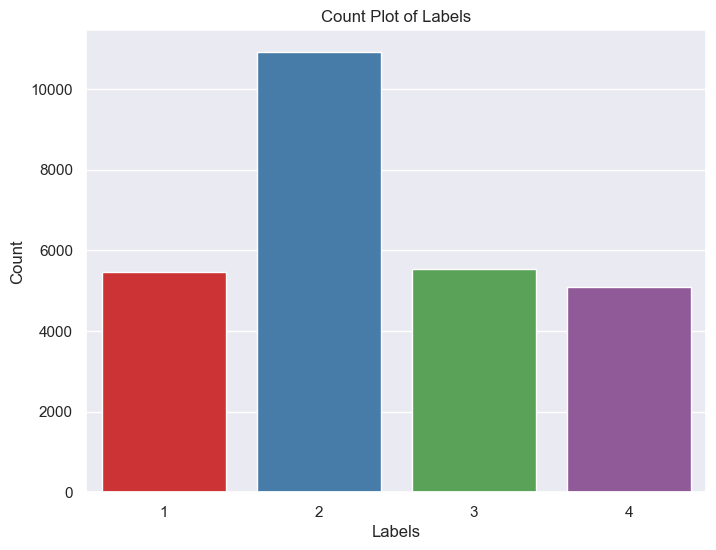

In [122]:
# Assuming you have a dataframe 'data' with a column named 'label'
sns.set(style="darkgrid")  # Set the style of the plot

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='alpha', palette='Set1')  # Adjust 'data' and 'x' based on your dataframe
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count Plot of Labels')
plt.show()

In [123]:
sns.set(style='darkgrid')

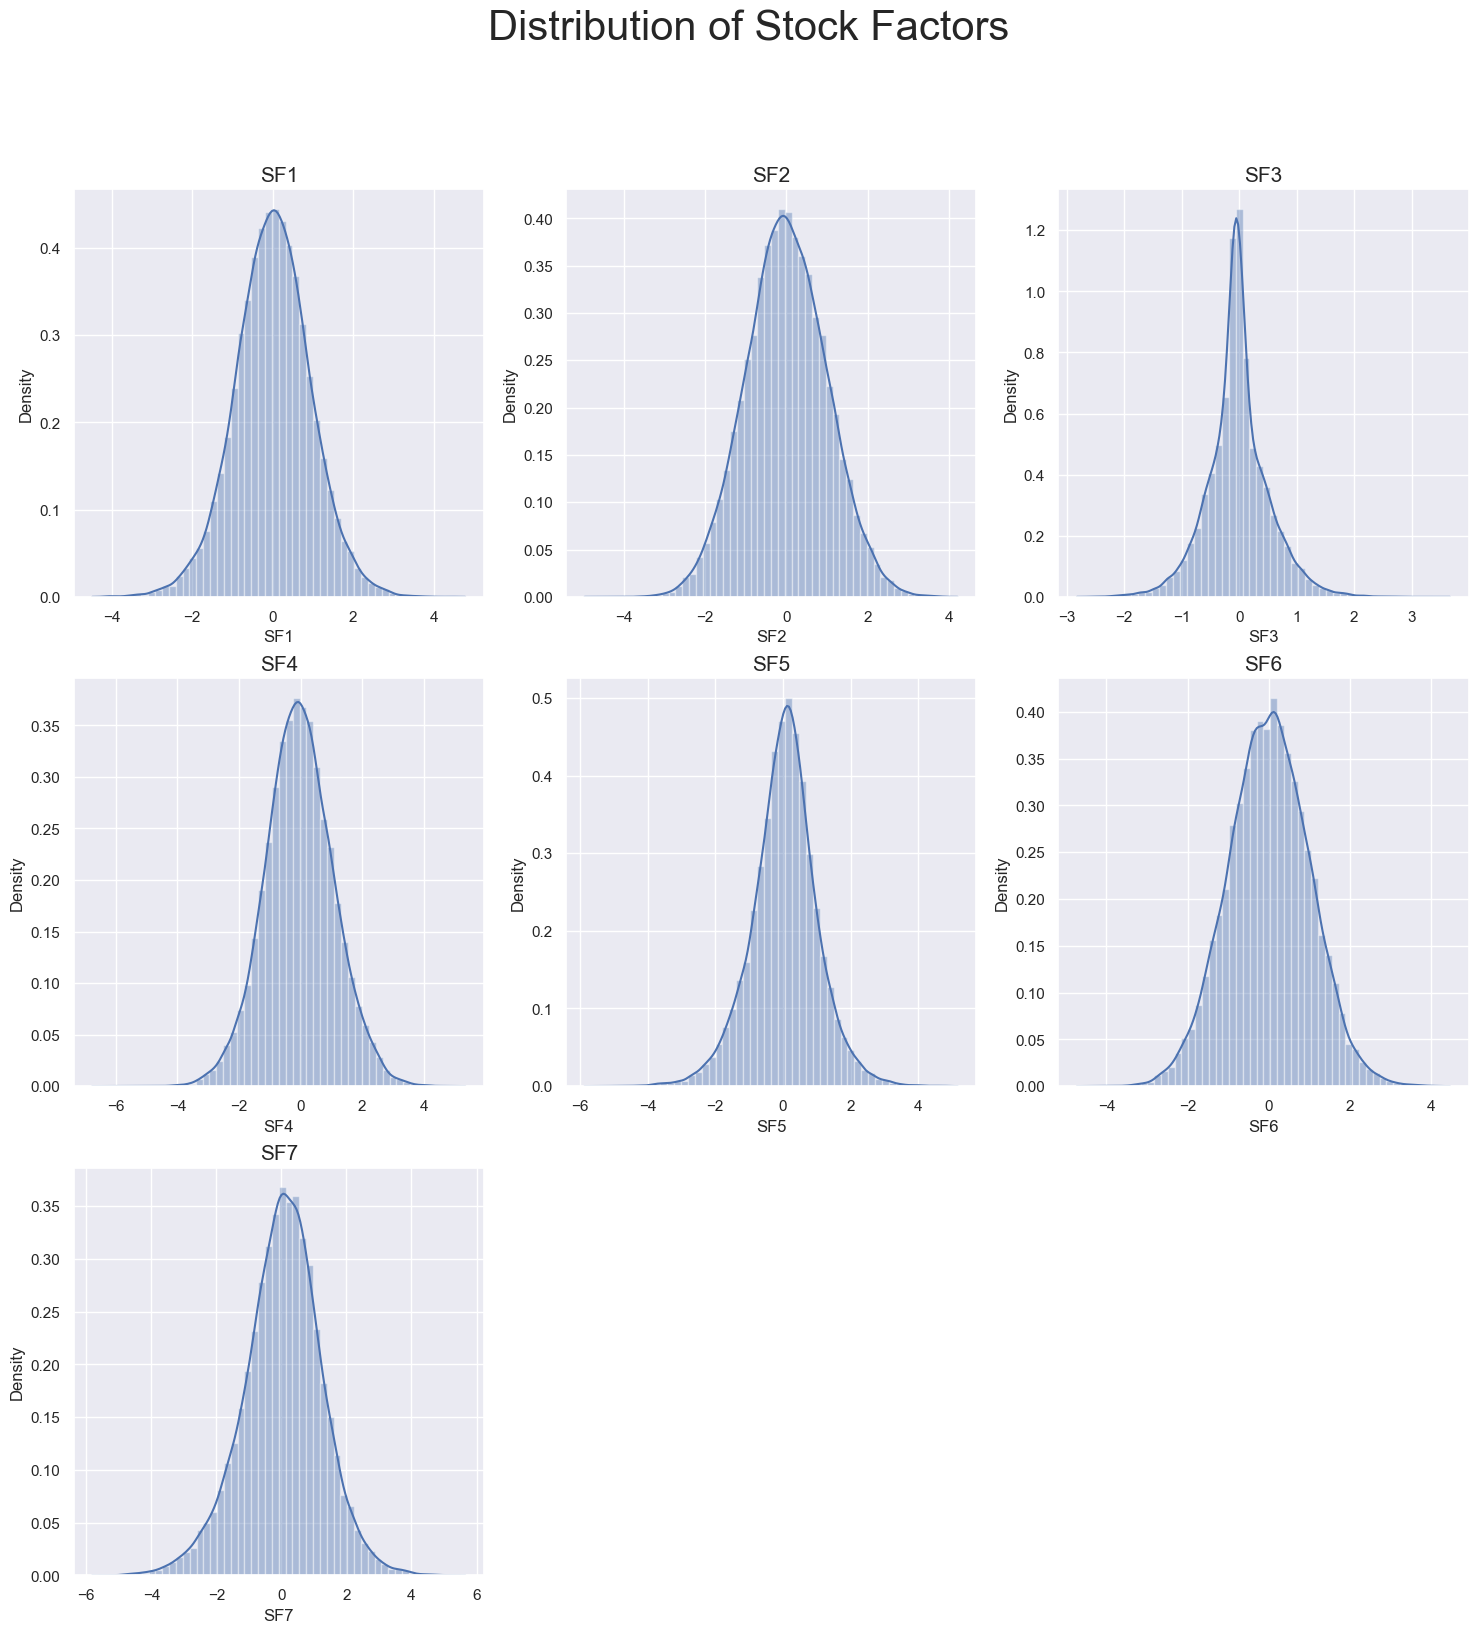

In [124]:
fig, ax = plt.subplots(figsize=(18,18))
fig.suptitle('Distribution of Stock Factors', fontsize = 30)

plt.subplot(331)
ax1 = sns.distplot(data['SF1'])
ax1.set_title('SF1', fontsize = 15)


plt.subplot(332)
ax2 = sns.distplot(data['SF2'])
ax2.set_title('SF2', fontsize = 15)


plt.subplot(333)
ax3 = sns.distplot(data['SF3'])
ax3.set_title('SF3', fontsize = 15)


plt.subplot(334)
ax4 = sns.distplot(data['SF4'])
ax4.set_title('SF4', fontsize = 15)


plt.subplot(335)
ax5 = sns.distplot(data['SF5'])
ax5.set_title('SF5', fontsize = 15)


plt.subplot(336)
ax6 = sns.distplot(data['SF6'])
ax6.set_title('SF6', fontsize = 15)

plt.subplot(337)
ax7 = sns.distplot(data['SF7'])
ax7.set_title('SF7', fontsize = 15)


plt.show()

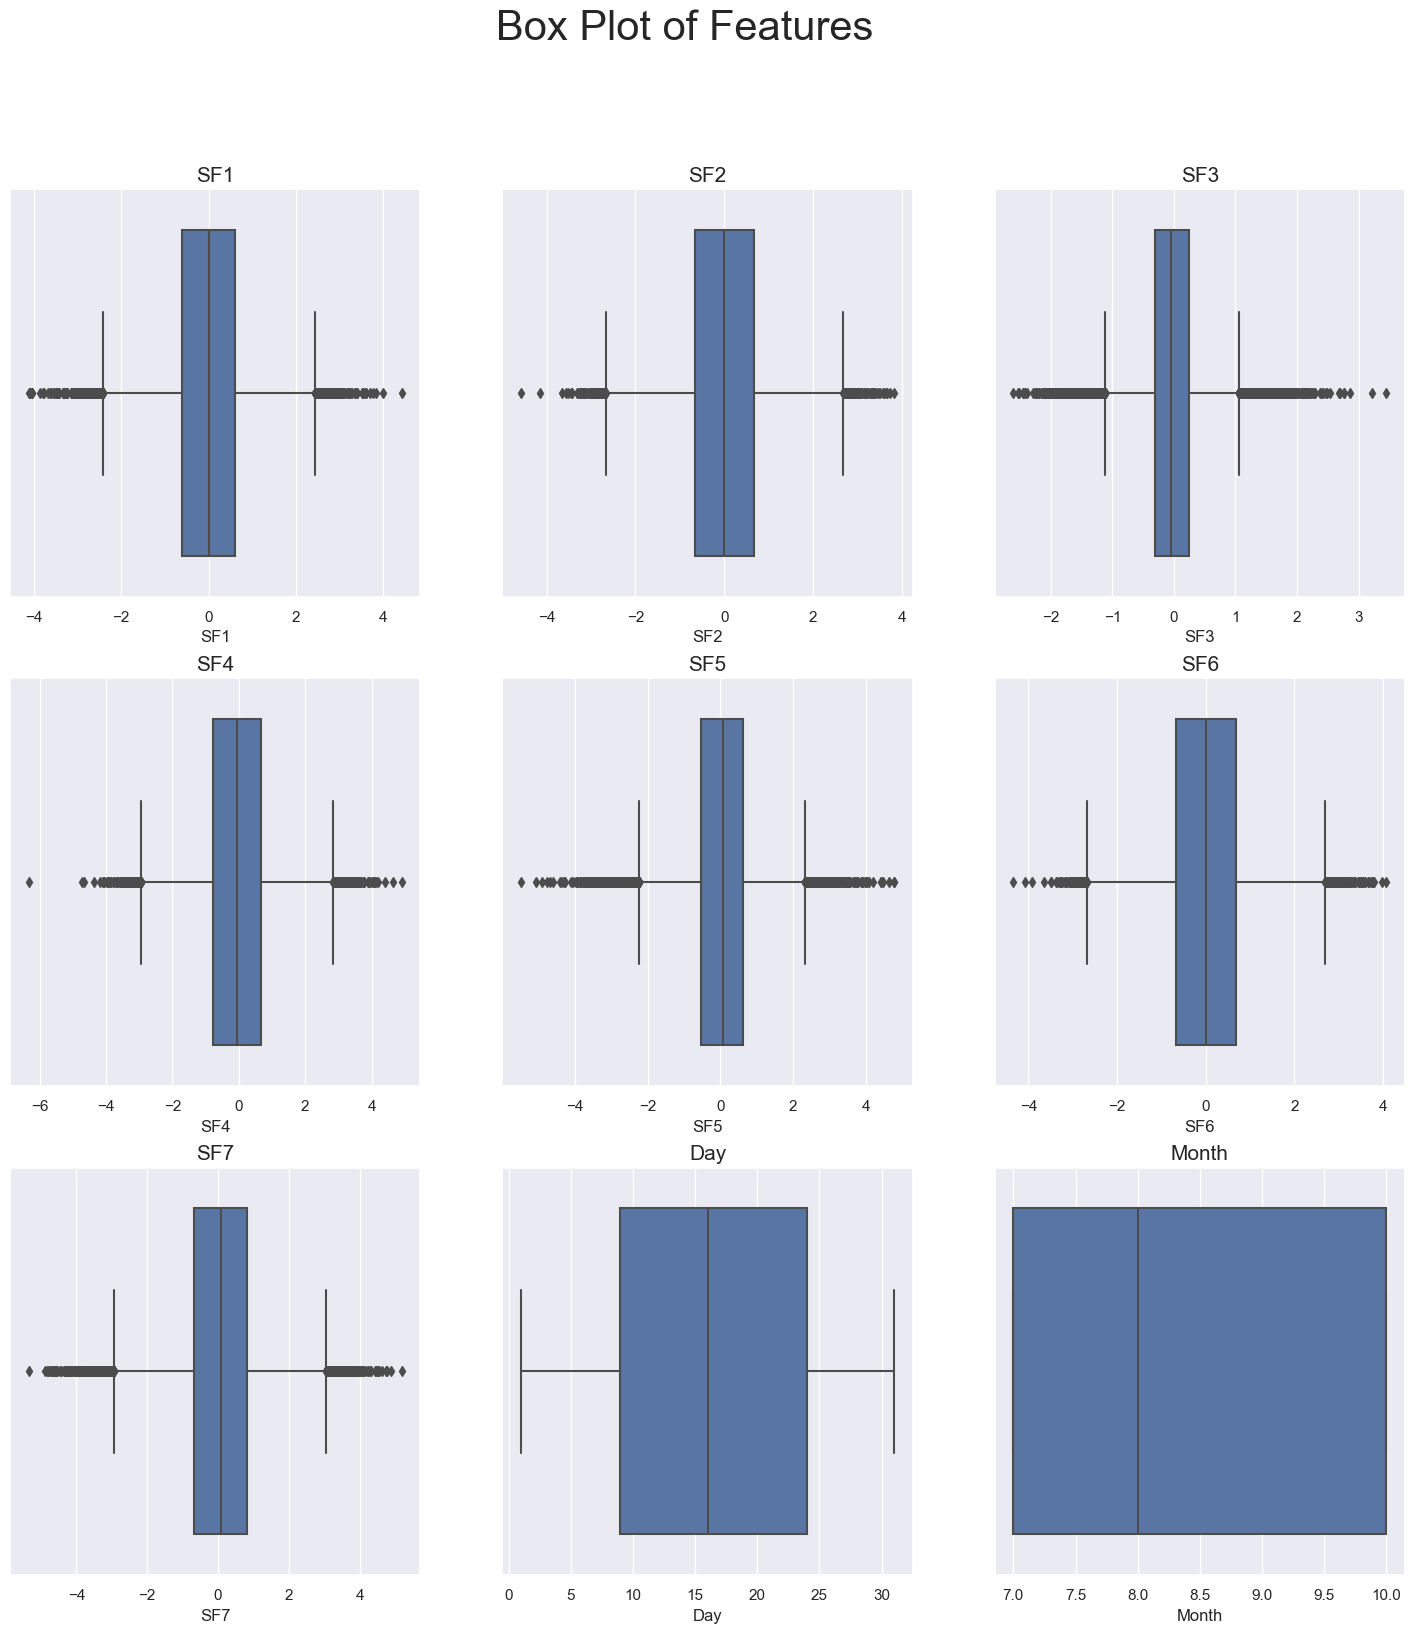

In [125]:
fig, ax = plt.subplots(figsize=(18,18))
fig.suptitle('Box Plot of Features', fontsize = 30)

plt.subplot(331)
ax1 = sns.boxplot(data['SF1'])
ax1.set_title('SF1', fontsize = 15)


plt.subplot(332)
ax2 = sns.boxplot(data['SF2'])
ax2.set_title('SF2', fontsize = 15)


plt.subplot(333)
ax3 = sns.boxplot(data['SF3'])
ax3.set_title('SF3', fontsize = 15)


plt.subplot(334)
ax4 = sns.boxplot(data['SF4'])
ax4.set_title('SF4', fontsize = 15)


plt.subplot(335)
ax5 = sns.boxplot(data['SF5'])
ax5.set_title('SF5', fontsize = 15)


plt.subplot(336)
ax6 = sns.boxplot(data['SF6'])
ax6.set_title('SF6', fontsize = 15)

plt.subplot(337)
ax7 = sns.boxplot(data['SF7'])
ax7.set_title('SF7', fontsize = 15)

plt.subplot(338)
ax8 = sns.boxplot(data['Day'])
ax8.set_title('Day', fontsize = 15)

plt.subplot(339)
ax9 = sns.boxplot(data['Month'])
ax9.set_title('Month', fontsize = 15)


plt.show()

<AxesSubplot:xlabel='ticker', ylabel='Density'>

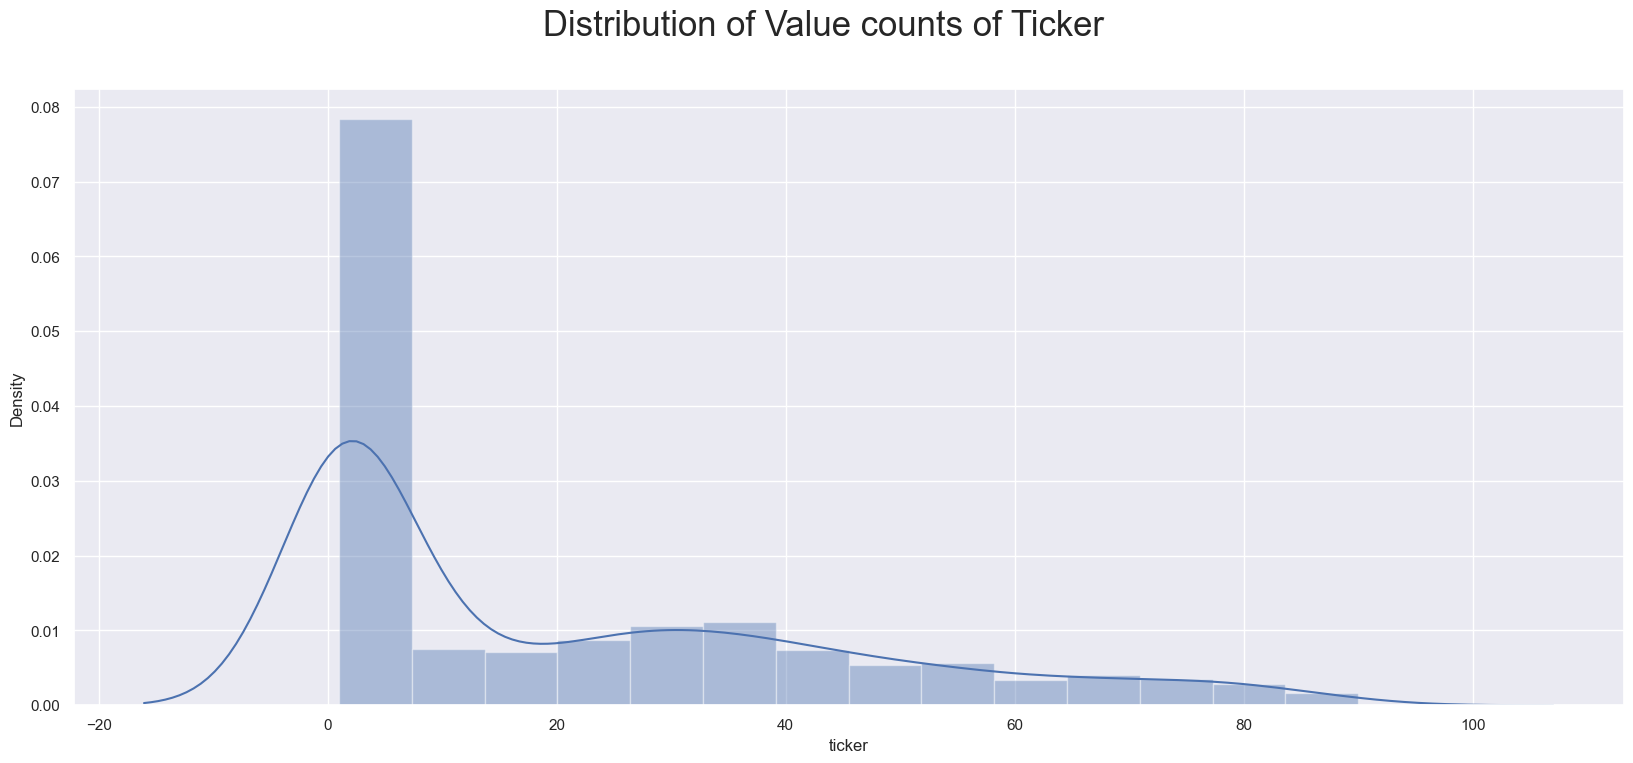

In [126]:
f,ax=plt.subplots(figsize = (20,8))
f.suptitle('Distribution of Value counts of Ticker', fontsize = 25)
sns.distplot(data['ticker'].value_counts())

<AxesSubplot:>

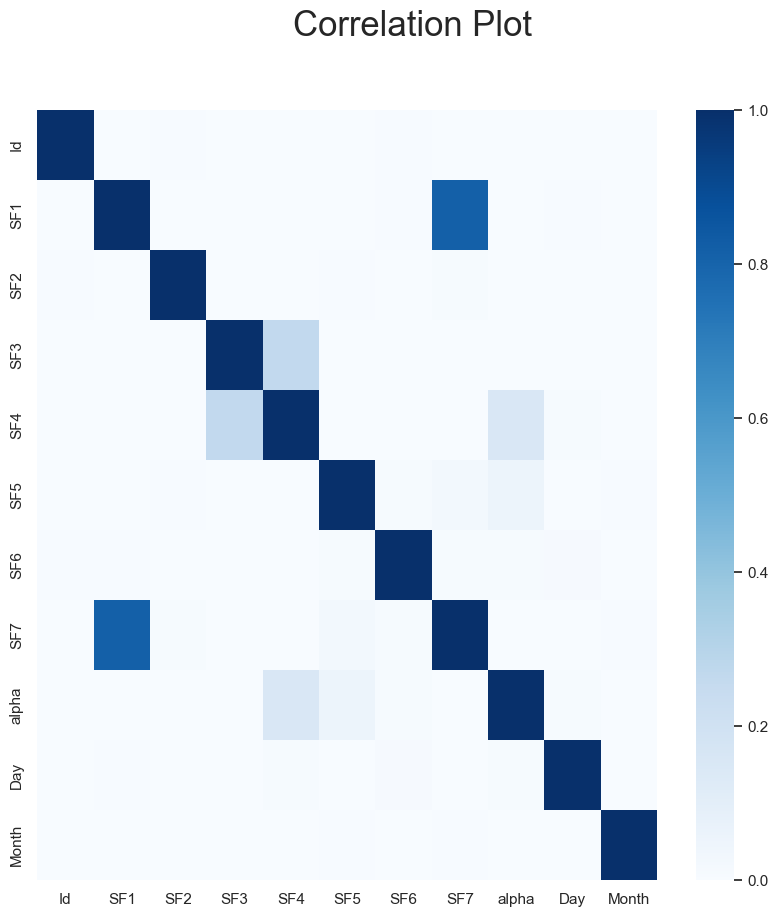

In [127]:
corr = data.corr()
f,ax=plt.subplots(figsize = (10,10))
f.suptitle('Correlation Plot', fontsize = 25)
sns.heatmap(corr, cmap = "Blues", vmin=0, vmax=1)

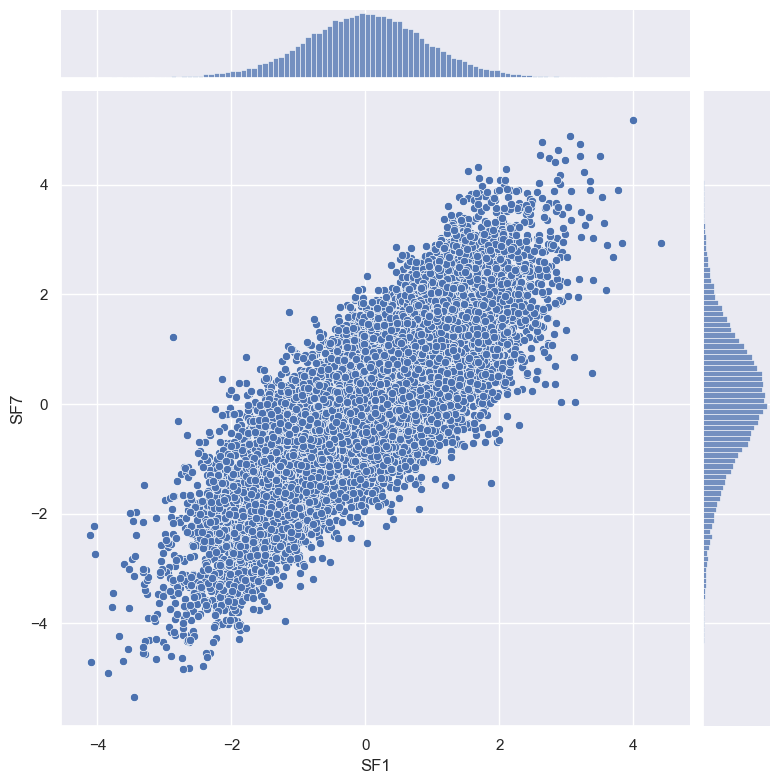

In [128]:
f.suptitle('Distribution of SF1 with SF7', fontsize = 25)
sns.jointplot(x = data['SF1'], y = data['SF7'], height = 8, ratio = 8)

In [129]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
0,1,21/08/18,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,8
1,2,11/10/18,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,10
2,3,21/08/18,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,21,8
3,4,10/07/18,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,10,7
4,5,12/09/18,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,12,9


In [130]:
data = data.drop('date', axis=1)

In [131]:
data.isnull().sum()

Id        0
ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
alpha     0
Day       0
Month     0
dtype: int64

In [132]:
data.ticker  .unique()

['NTAP', 'WYNN', 'DRI', 'ge', 'FE', ..., 'hrs', 'UNIT', 'GEVO', 'QTM', 'afl']
Length: 1300
Categories (1300, object): ['', 'A', 'AA', 'AABA', ..., 'yum', 'zbh', 'zion', 'zts']

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming data is your DataFrame and 'ticker' is the text-based column
ticker_data = data['ticker']

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'ticker' data using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(ticker_data)

# Convert the TF-IDF matrix to a DataFrame for easier analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Drop the original 'ticker' column from the data DataFrame
data = data.drop('ticker', axis=1)

# Concatenate the original data without the 'ticker' column with the TF-IDF DataFrame
data = pd.concat([data, tfidf_df], axis=1)

In [134]:
data

,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,...,yelp,yext,yum,zbh,zion,zoes,zto,zts,zumz,zuo
0,1,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27001,27002,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27002,27003,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27003,27004,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27004,27005,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
#X  AND Y

In [136]:
X=data.drop('alpha', axis=1)
X

,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month,...,yelp,yext,yum,zbh,zion,zoes,zto,zts,zumz,zuo
0,1,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,21,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,11,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,21,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,10,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,12,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27001,27002,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,5,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27002,27003,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,30,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27003,27004,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,16,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27004,27005,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,27,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
y=data['alpha']
y

0        2
1        3
2        1
3        2
4        2
        ..
27001    3
27002    3
27003    2
27004    3
27005    2
Name: alpha, Length: 27006, dtype: int64

In [138]:
#Splitting

In [139]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [140]:
X_train.shape

(21604, 866)

In [141]:
X_test.shape

(5402, 866)

In [142]:
# MODEL BUILDING

In [143]:
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [144]:
y_pred = clf.predict(X_test)

In [145]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6384672343576453
Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.50      0.52      1097
           2       0.78      0.85      0.81      2153
           3       0.48      0.45      0.46      1114
           4       0.57      0.56      0.56      1038

    accuracy                           0.64      5402
   macro avg       0.59      0.59      0.59      5402
weighted avg       0.63      0.64      0.63      5402



In [146]:
confusionmatrix=confusion_matrix(y_test, y_pred)
confusionmatrix

array([[ 550,  161,  256,  130],
       [ 111, 1823,  116,  103],
       [ 248,  164,  497,  205],
       [ 115,  186,  158,  579]], dtype=int64)

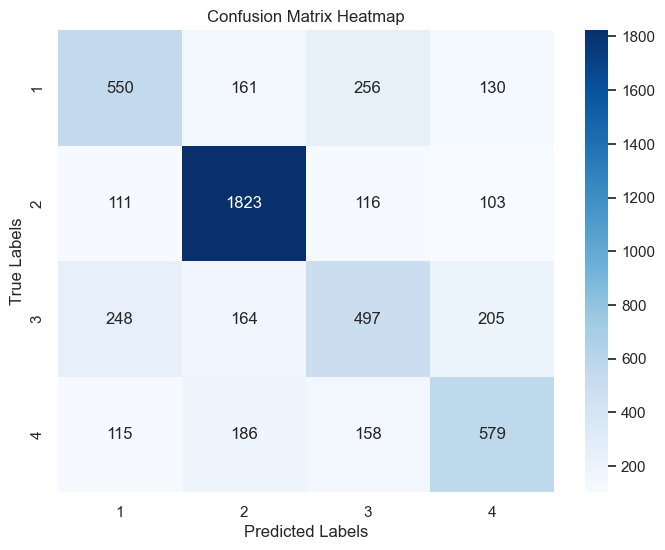

In [147]:

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusionmatrix, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [148]:
#XGBOOST CLASSIFIER

In [ ]:
# Check if the model file exists
model_filename = 'xgboost_model.pkl'
if os.path.exists(model_filename):
    # Load the trained model
    clf = joblib.load(model_filename)
    print(f"Model loaded from {model_filename}")
else:
    # Train the XGBoost classifier
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    clf = xgb.XGBClassifier()
    clf.fit(X_train, y_train)
    
    # Save the trained model to a file
    joblib.dump(clf, model_filename)
    print(f"Model saved as {model_filename}")

# Make predictions on the test set using the loaded or trained model
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test[:10], y_pred[:10])*100
print('Accuracy:', accuracy)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [ ]:
report=classification_report(y_test, y_pred)
print(report)